In [15]:
#importing all the required libraries
import pandas as pd
import os
import spacy
import re
from matplotlib import pyplot as plt
from string import punctuation
import nltk
from nltk.tokenize import regexp_tokenize
import numpy as np
from sklearn.metrics import classification_report,f1_score
#pip install pycontractions
import tensorflow as tf
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from tensorflow.keras.layers import Embedding,SpatialDropout1D,LSTM,Dense,Activation,Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer

In [86]:
#importing the datafile
df = pd.read_csv('Customer_Service_Questions_Multiclass.csv')
df.rename(columns = {'question':'customer_query'},inplace =True)

In [87]:
#loading the spacy's english language model.
sp = spacy.load('en_core_web_sm')
spacy_stopwords = sp.Defaults.stop_words

In [88]:
#using spacy stopwords to clean because spacy stopwords list is larger(320) when compared to the nltk(179).
#For this dataset, words which are unique will help in classifying the topic rather than regular words. 
#So using spacy could be more appropriate
def clean_text(text):
    words = regexp_tokenize(text.lower(),r'[a-zA-Z]+')
    words = [w for w in words if w not in spacy_stopwords and len(w)>2]
    return ' '.join(words)
    

In [89]:
#cleaning the text and appending it to a list
text_cleaned = []
for i in range(0,len(df)):
    text_cleaned.append(clean_text(df['customer_query'][i]))
df['cleaned_text'] = text_cleaned

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text major ticklabel objects>)

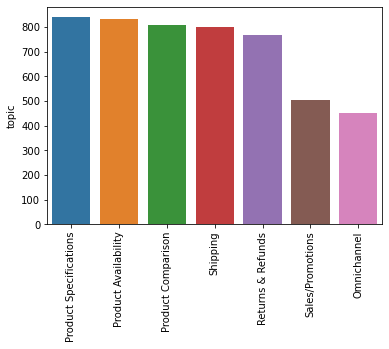

In [90]:
#EDA
# we can see that omnichannel, sales/promotions categories have less number of queries(almost 40% less) than others
import seaborn as sns
sns.barplot(df['topic'].value_counts().index,df['topic'].value_counts())
plt.xticks(rotation = 'vertical')

In [91]:
#splitting the dataset using stratified split to avoid sampling bias
from sklearn.model_selection import train_test_split
X_train,X_valid,y_train,y_valid = train_test_split(df['cleaned_text'],df['topic'],test_size = 0.25, shuffle = True, stratify = df['topic']) 

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text major ticklabel objects>)

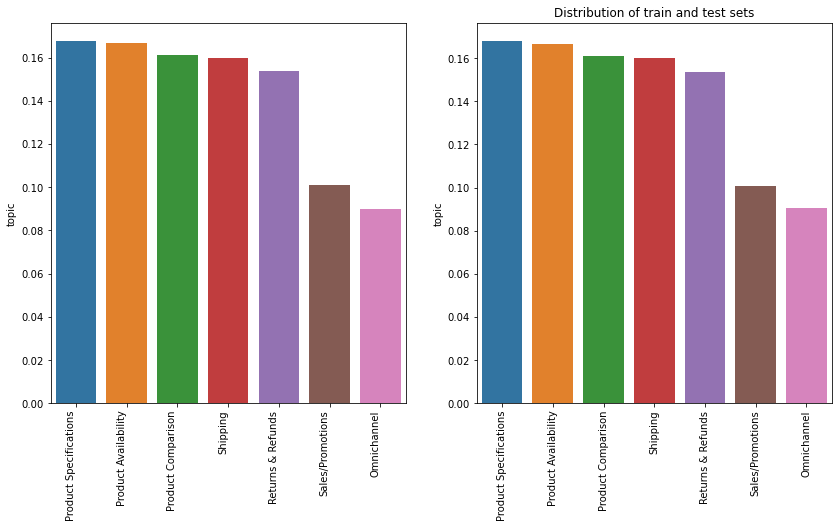

In [92]:
#checking the split of the dataset
ratio1 = y_train.value_counts()/len(y_train)
ratio2 = y_valid.value_counts()/len(y_valid)
f, axes = plt.subplots(1, 2, figsize=(14, 7), sharex=True)
plt.title('Distribution of train and test sets')
sns.barplot(ratio1.index,ratio1,ax=axes[0])
plt.setp(axes[0].get_xticklabels(), rotation=90, ha='right')
sns.barplot(ratio2.index,ratio2,ax=axes[1])
plt.xticks(rotation='vertical')


Due to the stratified split, all the topics in y_train and y_test have the same distribution

In [93]:
#encoding the topic variable
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_valid = le.transform(y_valid)

# Sparse vectorization

Considering only tfidf and not count vector because we need to form a vector where it gives more importance to words like availability, shipping, delivering which are less common than high frequency words. Count vectorization gives importance to high frequency words unlike tfidf.

Using Random_Search to find out the best hyper-parameters to find the best model parameters

In [94]:
#vectorization
#Tfidf vectorizer is better than count vectorizer in this context because in the queries, words like ship,availability words
#should have more importance than regular words
#n-grams --> it can be meaningful to try in this case as the combination of words could help in classifying the category

#creating a pipeline for vectorization and modelling

#model1
pipe_log = Pipeline(steps=[("tfidf",TfidfVectorizer(analyzer='word',token_pattern= r'\w+')),("classifier",LogisticRegression())])
#model2
pipe_ensemble = Pipeline(steps=[("tfidf",TfidfVectorizer(analyzer='word',token_pattern= r'\w+')),("RandomForestclassifier",RandomForestClassifier())])

In [95]:
#Explanaition of hyper-paramters: I chose the following hyper-parameters to tune because I think these are few important parameters to tune in this context
#sovler --> different types of optimizers for multi-class problem
#max_df --> maximum document frequency, where it elimates words based on the given document frequency
#ngram_range --> (1,1) specifies unigrams or words and other patters specifies minimum grams and max-grams(uni,bi,tri,4-grams)
#class_weight --> by default, it gives equal weight to all labels, balanced adjusts the weight automatically according to the distribution
#max_features --> maximum features in the tfidf vector
hyper_params_log = {
 'tfidf__max_df': [0.85,0.90,0.95],
 'tfidf__max_features': [1000,2000,3000,4000,5000],
 'tfidf__ngram_range': [(1,1),(1,2),(1,3),(1,4),(2,3),(2,4)],
 'classifier__class_weight': ['balanced',None],
 'classifier__max_iter': [100,200,300],
 'classifier__solver': ['newton-cg', 'lbfgs', 'sag', 'saga']

 
}

In [96]:
#Explanaition of hyper-paramters: I chose the following hyper-parameters to tune because I think these are few important parameters to tune in this context
#sovler --> different types of optimizers for multi-class problem
#max_df --> maximum document frequency, where it elimates words based on the given document frequency
#ngram_range --> (1,1) specifies unigrams or words and other patters specifies minimum grams and max-grams(uni,bi,tri,4-grams)
#class_weight --> balanced adjusts the weight automatically according to the frequency, balanced_subsample adjusts according to sampled trees
#tfidf_max_features --> maximum features in the tfidf vector
#criterion --> gini and entropy, two different techniques to split a node
#max-features --> maximum number of features when splitting
hyper_params_randomforest = {
 'tfidf__max_df': [0.85,0.90,0.95],
 'tfidf__max_features': [1000,2000,3000,4000,5000],
 'tfidf__ngram_range': [(1,1),(1,2),(1,3),(1,4),(2,3),(2,4)],
 'RandomForestclassifier__class_weight': ['balanced', 'balanced_subsample'],
 'RandomForestclassifier__criterion': ['gini','entropy'],
'RandomForestclassifier__max_features': ['auto', 'log2'], 
}

In [97]:
def hyper_parameter_tuning(pipe,hyper_params):
    random_search = RandomizedSearchCV(pipe,param_distributions= hyper_params, n_jobs= 4, cv= 10, random_state = 42)
    random_search.fit(X_train,y_train)
    y_predict = random_search.predict(X_valid)
    return random_search.best_estimator_,f1_score(y_predict,y_valid,average='weighted'),classification_report(y_valid,y_predict,output_dict=True),random_search

In [98]:
hp,f1_score_log,cr1,log_model = hyper_parameter_tuning(pipe_log,hyper_params_log)
print('Best paramters for Logistic Regression are',hp)
print('F1 score for Logistion Regression is',f1_score_log)



Best paramters for Logistic Regression are Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.9, max_features=4000,
                                 ngram_range=(1, 3), token_pattern='\\w+')),
                ('classifier',
                 LogisticRegression(class_weight='balanced', max_iter=300))])
F1 score for Logistion Regression is 0.9401840939642522


In [99]:
hp2,f1_score_random,cr2,randomforest_model = hyper_parameter_tuning(pipe_ensemble,hyper_params_randomforest)

print('Best paramters for RandomForestClassifier are',hp2)
print('F1 score for RandomForest Classifier is',f1_score_random)

Best paramters for RandomForestClassifier are Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.9, max_features=5000,
                                 ngram_range=(1, 2), token_pattern='\\w+')),
                ('RandomForestclassifier',
                 RandomForestClassifier(class_weight='balanced',
                                        max_features='log2'))])
F1 score for RandomForest Classifier is 0.9559246264924052


Choosing F1 score as my evaluation metric: Reason--> Accuracy is notoriously misleading if we have an imbalanced dataset. we have few imbalanced classes and accuracy is not a good metric in this context. Precision & Recall can say a lot but F1 score will give the comprehensive look as it is the harmonic mean of precision and recall of our model in the evaluation. Confusion matrix is a good evaluation measure but it is sometimes it is hard to interpet when we have multiple classes. So, I am choosing F1 score because of interpretability and also the gives an overall performance of the model.(F1 score will be high if both precison and recall are high(ideal case))

model3 --> Simple DNN: I chose this model because after some study on internet, Deep neural networks are showing great improvement in text classification than tradition machine learning models according to https://arxiv.org/pdf/2004.03705.pdf paper. I have also tried LSTM with Tfidf vector(but it is taking more time to run on a dense vector and results are not good when I compare with the DNN)

In [100]:
#reducing the dimensions to only 1000
#tokenizing the clean text using tensorflow tokenizer and converting into tfidf matrix
tokenizer = Tokenizer(num_words= 1000,char_level=False)
tokenizer.fit_on_texts(df['cleaned_text'].values)
X = tokenizer.texts_to_sequences(df['cleaned_text'].values)
X = tokenizer.sequences_to_matrix(X,mode='tfidf')

In [101]:
y = pd.get_dummies(df['topic']).values

In [102]:
#splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.20, random_state = 42, stratify = y)
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(4000, 1000) (4000, 7)
(1000, 1000) (1000, 7)


In [103]:
#model building

In [104]:
#Created a DNN with hidden layer1 512 nodes, hidden layer 256 nodes with dropouts(regularization parameter to reduce the risk of overfitting)
#activation function for hidden layer nodes is relu and output layer is softmax(because it will give probabilites for multi-class)
#sequential model
model = Sequential()
model.add(Dense(512, input_shape=(1000,)))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(7))
model.add(Activation('softmax'))

In [105]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 512)               512512    
_________________________________________________________________
activation_6 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               131328    
_________________________________________________________________
activation_7 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 7)                

In [106]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [107]:
model_history = model.fit(X_train, y_train, epochs=10,shuffle=True,verbose = True, batch_size=64,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss', patience=5)])

Epoch 1/10
50/50 [==============================] - 1s 15ms/step - loss: 0.8998 - accuracy: 0.7066 - val_loss: 0.2373 - val_accuracy: 0.9237
Epoch 2/10
50/50 [==============================] - 0s 9ms/step - loss: 0.1515 - accuracy: 0.9534 - val_loss: 0.1648 - val_accuracy: 0.9475
Epoch 3/10
50/50 [==============================] - 0s 9ms/step - loss: 0.0562 - accuracy: 0.9850 - val_loss: 0.1960 - val_accuracy: 0.9463
Epoch 4/10
50/50 [==============================] - 1s 11ms/step - loss: 0.0297 - accuracy: 0.9944 - val_loss: 0.1800 - val_accuracy: 0.9513
Epoch 5/10
50/50 [==============================] - 0s 10ms/step - loss: 0.0200 - accuracy: 0.9956 - val_loss: 0.2089 - val_accuracy: 0.9463
Epoch 6/10
50/50 [==============================] - 0s 9ms/step - loss: 0.0130 - accuracy: 0.9981 - val_loss: 0.2208 - val_accuracy: 0.9475
Epoch 7/10
50/50 [==============================] - 0s 9ms/step - loss: 0.0158 - accuracy: 0.9981 - val_loss: 0.2675 - val_accuracy: 0.9413


In [108]:
y_predict = model.predict_classes(X_test)
y_test_decoded = np.argmax(y_test,axis=1)

In [109]:
cr3 = classification_report(y_test_decoded,y_predict,output_dict= True)

In [110]:
df1 = pd.DataFrame(cr1).transpose()
df2 = pd.DataFrame(cr2).transpose()
df3 = pd.DataFrame(cr3).transpose()

In [111]:
print('classification report for Logistic Regression',df1)

classification report for Logistic Regression               precision    recall  f1-score  support
0              1.000000  0.982301  0.991071   113.00
1              0.924171  0.937500  0.930788   208.00
2              0.860577  0.890547  0.875306   201.00
3              0.888889  0.838095  0.862745   210.00
4              0.994764  0.989583  0.992167   192.00
5              0.954545  1.000000  0.976744   126.00
6              0.994975  0.990000  0.992481   200.00
accuracy       0.940000  0.940000  0.940000     0.94
macro avg      0.945417  0.946861  0.945900  1250.00
weighted avg   0.940106  0.940000  0.939816  1250.00


In [112]:
print('classification report for RandomForestClassifier',df2)

classification report for RandomForestClassifier               precision    recall  f1-score   support
0              1.000000  0.991150  0.995556   113.000
1              0.882096  0.971154  0.924485   208.000
2              0.956989  0.885572  0.919897   201.000
3              0.918269  0.909524  0.913876   210.000
4              0.994737  0.984375  0.989529   192.000
5              0.984252  0.992063  0.988142   126.000
6              1.000000  0.990000  0.994975   200.000
accuracy       0.956000  0.956000  0.956000     0.956
macro avg      0.962335  0.960548  0.960923  1250.000
weighted avg   0.957338  0.956000  0.956075  1250.000


In [113]:
print('classification report for Neural Network',df3)

classification report for Neural Network               precision    recall  f1-score   support
0              1.000000  0.977778  0.988764    90.000
1              0.898876  0.963855  0.930233   166.000
2              0.912500  0.906832  0.909657   161.000
3              0.923567  0.863095  0.892308   168.000
4              0.980892  1.000000  0.990354   154.000
5              1.000000  0.970297  0.984925   101.000
6              0.987654  1.000000  0.993789   160.000
accuracy       0.951000  0.951000  0.951000     0.951
macro avg      0.957641  0.954551  0.955718  1000.000
weighted avg   0.951367  0.951000  0.950768  1000.000


In [128]:
# Testing my own input
out_of_sample = ["Hi! I want to signup for your email list get advertisements for sale products and shopping clearence?",
                "I want to know about the iphone availability at your store",
                "Can I know the comparison between iphone 11 and iphone 11 pro mobiles",
                "Can you ship my product at my new jersey address on Monday?",
                "How can I return my earpods that I bought on Amazon last Monday?"]
out_sample_arr = []
for i in range(0,len(out_of_sample)):
    out_sample_arr.append(clean_text(out_of_sample[i]))

In [133]:
tokenizer.fit_on_texts(out_sample_arr)
X_out = tokenizer.texts_to_sequences(out_sample_arr)
X_out = tokenizer.sequences_to_matrix(X_out,mode='tfidf')

In [136]:
le.inverse_transform(log_model.predict(out_sample_arr))

array(['Sales/Promotions', 'Omnichannel', 'Product Specifications',
       'Product Comparison', 'Returns & Refunds'], dtype=object)

In [137]:
le.inverse_transform(randomforest_model.predict(out_sample_arr))

array(['Sales/Promotions', 'Omnichannel', 'Product Specifications',
       'Product Comparison', 'Returns & Refunds'], dtype=object)

In [138]:
le.inverse_transform(model.predict_classes(X_out))

array(['Sales/Promotions', 'Omnichannel', 'Product Specifications',
       'Product Specifications', 'Product Specifications'], dtype=object)

I have selected F1 score to compare the classifiers because it gives us a comprehensive look of model performance and also from classification report, we can see the f1scores for all the classes and interpet.

F1 score for RandomForestClassifier is the highest(0.965) out of all the classifiers. After comparing the output from out of sample test, RandomForest and Logistic has performed the same but neural network has predicted the last query as 'product specifications' rather than Returen & Refunds. Logistic and RandomForest has correctly predicted 3/5 samples. I would like to use RandomForestClassifier because of the high F1 score and the performance on the out-of-sample test for this dataset